# **Face Recognition**

**Before testing**

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566170 sha256=a340a2be252603080846f07f5d32c3e0ec92189a0075e488ef3a170e4fa815d2
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


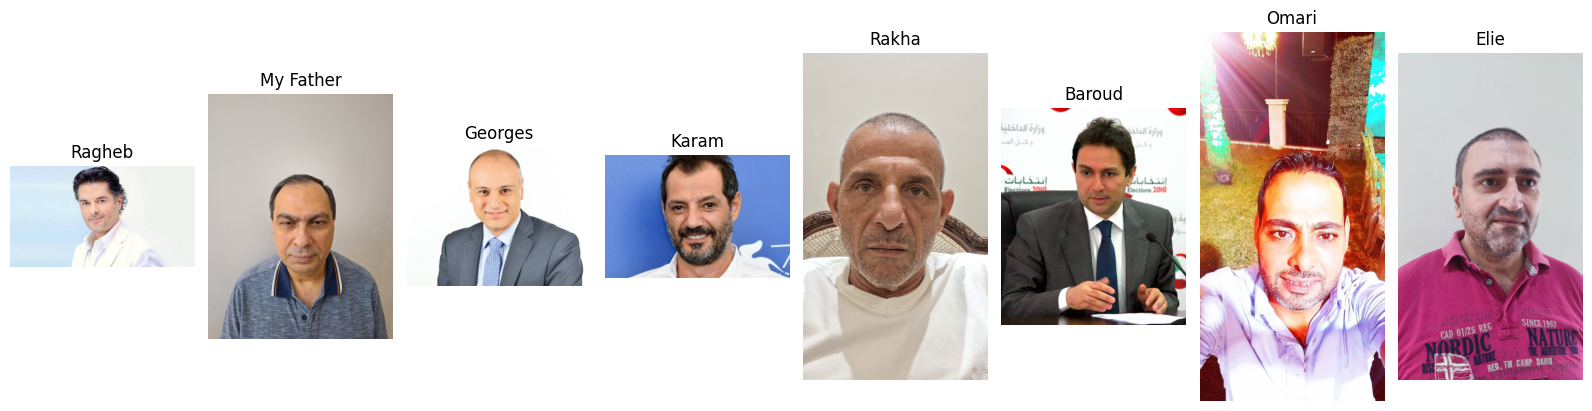

Image with recognized faces saved at: /content/drive/MyDrive/FRD/output/recognized_faces.jpg
Accuracy: 1.0
Image with recognized faces saved at: /content/drive/MyDrive/FRD/output/recognized_faces.jpg
Accuracy: 1.0
Image with recognized faces saved at: /content/drive/MyDrive/FRD/output/recognized_faces.jpg
Accuracy: 1.0
Image with recognized faces saved at: /content/drive/MyDrive/FRD/output/recognized_faces.jpg
Accuracy: 1.0
Image with recognized faces saved at: /content/drive/MyDrive/FRD/output/recognized_faces.jpg
Accuracy: 1.0
Image with recognized faces saved at: /content/drive/MyDrive/FRD/output/recognized_faces.jpg
Accuracy: 1.0
Image with recognized faces saved at: /content/drive/MyDrive/FRD/output/recognized_faces.jpg
Accuracy: 1.0
Image with recognized faces saved at: /content/drive/MyDrive/FRD/output/recognized_faces.jpg
Accuracy: 1.0
Image with recognized faces saved at: /content/drive/MyDrive/FRD/output/recognized_faces.jpg
Accuracy: 1.0
Image with recognized faces saved at:

In [1]:
# Mounting to google drive to retreive dataset
from google.colab import drive
drive.mount('/content/drive')

# Installing the face_recognition library
!pip install face_recognition

# Importing random for random training image visualization and matplotlib.pyplot for plotting
import matplotlib.pyplot as plt
import random

# Importing argparse for CLI(terminal) use
import argparse

# Importing pickle for saving encodings
import pickle

# Importing Counter for votes tracking
from collections import Counter

# Importing Path for path related commands
from pathlib import Path

# Importing face_recognition for face recognition
import face_recognition

# Importing Image and ImageDraw for drawing on an existing image
from PIL import Image, ImageDraw

# Paths to images and titles
image_paths = ["/content/drive/MyDrive/FRD/unknown.jpg", "/content/drive/MyDrive/FRD/output/recognized_faces.jpg"]
titles = ["Unknown Image", "Recognized Faces"]

# Default path here to save encodings
DEFAULT_ENCODINGS_PATH = Path("/content/drive/MyDrive/FRD/output/encodings.pkl")

# Defining bounding box and text color for face recognition
BOUNDING_BOX_COLOR = "blue"
TEXT_COLOR = "white"

# Parse command-line arguments for adding arguments in terminal
parser = argparse.ArgumentParser(description="Recognize faces in an image")
parser.add_argument("--train", action="store_true", help="Train on input data")
parser.add_argument(
    "--validate", action="store_true", help="Validate trained model"
)
parser.add_argument(
    "--test", action="store_true", help="Test the model with an unknown image"
)
parser.add_argument(
    "-m",
    action="store",
    default="hog",
    choices=["hog", "cnn"],
    help="Which model to use for training: hog (CPU), cnn (GPU)",
)
parser.add_argument(
    "-f", action="store", help="Path to an image with an unknown face"
)
args = parser.parse_args()

# Function to display bounding boxes and names on detected faces with 2 cases colors coloring
def _display_face(draw, bounding_box, name, is_known):
    """
    Draws bounding boxes around faces, a caption area, and text captions.
    """
    top, right, bottom, left = bounding_box
    if is_known:
        box_color = BOUNDING_BOX_COLOR
    else:
        box_color = "red"
    draw.rectangle(((left, top), (right, bottom)), outline=box_color)
    text_left, text_top, text_right, text_bottom = draw.textbbox(
        (left, bottom), name
    )
    draw.rectangle(
        ((text_left, text_top), (text_right, text_bottom)),
        fill=box_color,
        outline=box_color,
    )
    draw.text(
        (text_left, text_top),
        name,
        fill=TEXT_COLOR,
    )

# Function to recognize a face from its encoding
def _recognize_face(unknown_encoding, loaded_encodings):
    """
    Given an unknown encoding and all known encodings, it finds the known
    encoding with the most matches.
    """
    boolean_matches = face_recognition.compare_faces(
        loaded_encodings["encodings"], unknown_encoding
    )
    votes = Counter(
        name
        for match, name in zip(boolean_matches, loaded_encodings["names"])
        if match
    )
    if votes:
        return votes.most_common(1)[0][0]

# Function to encode known faces
def encode_known_faces(
    model: str = "hog", encodings_location: Path = DEFAULT_ENCODINGS_PATH
) -> None:
    """
    Loads images in the training directory, builds a dictionary of their
    names and encodings and displays one random image for each person present in a database.
    """
    # Displays a random image for each person in the training directory
    fig, axes = plt.subplots(1, 8, figsize=(16, 4))
    for ax, person_dir in zip(axes, Path("/content/drive/MyDrive/FRD/training").glob("*")):
        if person_dir.is_dir():
            name = person_dir.name
            image_files = list(person_dir.glob("*"))
            if image_files:
                random_image = random.choice(image_files)
                image = face_recognition.load_image_file(random_image)
                ax.imshow(image)
                ax.axis("off")
                ax.set_title(name)
    plt.tight_layout(pad=1.0)
    plt.show()
    # Encoding faces in the training images
    names = []
    encodings = []
    for person_dir in Path("/content/drive/MyDrive/FRD/training").glob("*"):
        if person_dir.is_dir():
            name = person_dir.name
            image_files = list(person_dir.glob("*"))
            if image_files:
                random_image = random.choice(image_files)
                image = face_recognition.load_image_file(random_image)
                face_locations = face_recognition.face_locations(image, model=model)
                face_encodings = face_recognition.face_encodings(image, face_locations, num_jitters=50)
                for encoding in face_encodings:
                    names.append(name)
                    encodings.append(encoding)
    name_encodings = {"names": names, "encodings": encodings}
    with encodings_location.open(mode="wb") as f:
        pickle.dump(name_encodings, f)

# Function to recognize faces in an image
def recognize_faces(
    image_location: str,
    model: str = "hog",
    encodings_location: Path = DEFAULT_ENCODINGS_PATH,
    output_location: str = "/content/drive/MyDrive/FRD/output/recognized_faces.jpg"
) -> float:
    """
    Given an unknown image, it gets the locations and encodings of faces,
    compares them against the known encodings to find potential matches and
    returns the accuracy of the recognition.
    """
    with encodings_location.open(mode="rb") as f:
        loaded_encodings = pickle.load(f)
    input_image = face_recognition.load_image_file(image_location)
    input_face_locations = face_recognition.face_locations(
        input_image, model=model
    )
    input_face_encodings = face_recognition.face_encodings(
        input_image, input_face_locations, num_jitters=50
    )
    pillow_image = Image.fromarray(input_image)
    draw = ImageDraw.Draw(pillow_image)
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0
    for bounding_box, unknown_encoding in zip(
        input_face_locations, input_face_encodings
    ):
        name = _recognize_face(unknown_encoding, loaded_encodings)
        if name:
            is_known = True
        else:
            is_known = False
            name = "Unknown"
        _display_face(draw, bounding_box, name, is_known)
        if is_known and name == "Unknown":
            false_positives += 1
        elif not is_known and name == "Unknown":
            true_negatives += 1
        elif is_known and name != "Unknown":
            true_positives += 1
        elif not is_known and name != "Unknown":
            false_negatives += 1
    accuracy = (true_positives + true_negatives) / (true_positives + false_negatives + false_positives + true_negatives)
    del draw
    pillow_image.save(output_location)
    print("Image with recognized faces saved at:", output_location)
    print("Accuracy:", accuracy)
    return accuracy

# Validation
def validate(model: str = "hog"):
    """
    It runs recognize_faces on a set of images with known faces to validate
    known encodings.
    """
    accuracies = []
    for filepath in Path("/content/drive/MyDrive/FRD/validation").rglob("*"):
        if filepath.is_file():
            accuracy = recognize_faces(image_location=str(filepath.absolute()), model=model)
            accuracies.append(accuracy)
    mean_accuracy = sum(accuracies) / len(accuracies)
    print("Mean Accuracy:", mean_accuracy)

# Function to display images horizontally
def display_images_horizontally(image_paths, titles, output_path):
    fig, axes = plt.subplots(1, len(image_paths), figsize=(4, 4))
    for ax, image_path, title in zip(axes, image_paths, titles):
        image = Image.open(image_path)
        ax.imshow(image)
        ax.axis("off")
        ax.set_title(title)
    plt.subplots_adjust(wspace=0)
    plt.savefig(output_path)
    plt.show()

'''def display_images_with_cropped_faces(image_paths, titles, output_path):
    fig, axes = plt.subplots(2, len(image_paths), figsize=(16, 8))
    for ax, image_path, title in zip(axes[0], image_paths, titles):
        image = Image.open(image_path)
        ax.imshow(image)
        ax.axis("off")
        ax.set_title(title)
    for i, person_dir in enumerate(Path("/content/drive/MyDrive/FRD/training").glob("*")):
        if person_dir.is_dir():
            image_files = list(person_dir.glob("*"))
            if image_files:
                random_image = random.choice(image_files)
                image = face_recognition.load_image_file(random_image)
                face_locations = face_recognition.face_locations(image, model=args.m)
                if face_locations:
                    top, right, bottom, left = face_locations[0]
                    cropped_face = image[top:bottom, left:right]
                    axes[1, i].imshow(cropped_face)
                    axes[1, i].axis("off")
                    axes[1, i].set_title(person_dir.name)
    plt.tight_layout(pad=1.0)
    plt.savefig(output_path)
    plt.show()'''

# Calling the function to encode known faces
encode_known_faces(model=args.m)

# display_images_with_cropped_faces(image_paths, titles, "/content/drive/MyDrive/FRD/output/display_result_with_cropped_faces.jpg")

# Validation
validate(model=args.m)

**Testing**

Image with recognized faces saved at: /content/drive/MyDrive/FRD/output/recognized_faces.jpg
Accuracy: 1.0


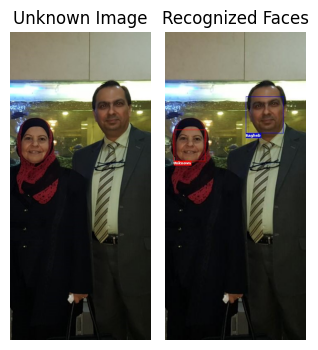

In [2]:
# Recognizing faces in unknown image
recognize_faces(image_location="/content/drive/MyDrive/FRD/unknown.jpg", model=args.m)

# Displaying images horizontally
display_images_horizontally(image_paths, titles, "/content/drive/MyDrive/FRD/output/display_result.jpg")

* Seeing how similar 2 faces are instead of just checking if they match or not can be done by using the **face_distance** fonction.
* The model implemented here was trained in a way that faces with a distance of **0.6** or less matches.
* For a more strict approch, looking for a **smaller** face distance could be done.
* **For exemple**, using a **0.55 cutoff reduces false positive matches at the cost of higher false negatives**.
* In a case where higher security mesures are demanded, lowering the **face_distance** fonction could be done.